# Stars Per Contributor

###  Draft RPGF3 List ✨

In [1]:
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_04_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "StarsPerContributor"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-04_StarsPerContributor.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list awards tokens based on the ratio of aggregate stars to aggregate contributors.",
                "First, we calculate the total number of stars a project has across all its repos.",
                "Then, we identify the total number of unique contributors over the lifetime of the project.",
                "Finally, we calculate the ratio of stars to contributors for a project."
                "The list awards OP Tokens pro-rata to that project based on this ratio.",
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            'OP_STACK'
            ]

AWARD_AMT = 1.5 * 10e6

JSON_PATH = DATA_DIR + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
#duplicates = oso.check_duplicate_slugs()

Loaded 308 OSS projects from data/RPGF3/2023-11_04_RPGF3_cleaned_applicant_data.json.
Identified 308 unique slugs.


# Get the data to power the list

In [16]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)

query = f"""
    WITH StarContributorCounts AS (
        SELECT 
            p.slug AS slug,
            SUM(CASE WHEN e."typeId" = 14 THEN e.amount ELSE 0 END) AS star_count,
            COUNT(DISTINCT CASE WHEN e."typeId" IN (2, 3, 4, 6, 18) THEN e."fromId" END) AS contributor_count
        FROM 
            project p
        LEFT JOIN 
            project_artifacts_artifact paa ON p."id" = paa."projectId"
        LEFT JOIN 
            event e ON e."toId" = paa."artifactId" 
                     AND (e."typeId" = 14 OR e."typeId" IN (2, 3, 4, 6, 18))
        WHERE 
            p.slug IN ('{slugs_list}')
        GROUP BY 
            p.slug
    )
    SELECT 
        slug,
        star_count/ contributor_count
    FROM 
        StarContributorCounts
    WHERE
        contributor_count > 0;
"""

results = execute_query(query, col_names=False)

In [25]:
# transform query results

stars_per_contrib = {project: ratio for (project,ratio) in results}

# Generate the list

In [26]:
named_list = listify(stars_per_contrib, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

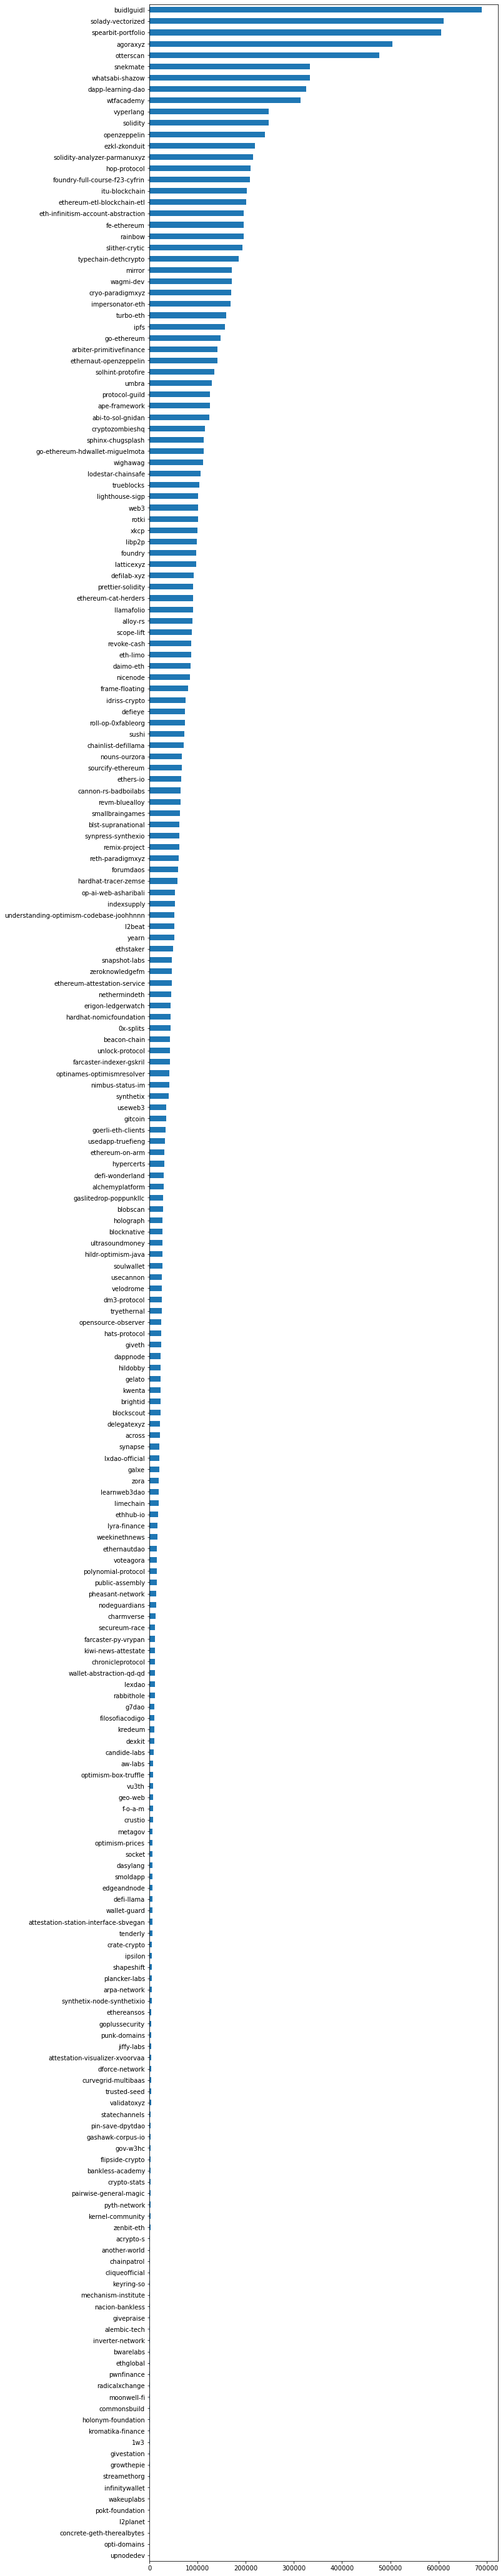

In [27]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)